In [84]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import linear_model, neighbors
from sklearn.feature_selection import mutual_info_regression, RFE, mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from rmse import compute_rmse
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mutual_info_score
import math
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import bootstrap_point632_score
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [36]:
X1_select = pd.read_csv("X1.csv") 
Y1 = pd.read_csv("Y1.csv", header=None, names=["shares"])
X_full = pd.read_csv("X1.csv")

In [37]:
n_samples, n_feats = X1_select.shape
X1_select.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,10.0,379.0,0.521622,1.0,0.697248,5.0,2.0,1.0,0.0,4.126649,...,0.368452,0.1,0.5,-0.244444,-0.500000,-0.050000,0.227273,0.068182,0.272727,0.068182
1,12.0,402.0,0.502660,1.0,0.645299,12.0,10.0,1.0,0.0,4.537313,...,0.270170,0.1,0.5,-0.159259,-0.166667,-0.155556,0.500000,0.500000,0.000000,0.500000
2,11.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
3,9.0,256.0,0.619608,1.0,0.792208,2.0,0.0,0.0,1.0,4.644531,...,0.245130,0.1,1.0,-0.500000,-0.500000,-0.500000,0.200000,0.100000,0.300000,0.100000
4,12.0,268.0,0.591603,1.0,0.740260,1.0,1.0,1.0,1.0,4.671642,...,0.539076,0.2,1.0,-0.254167,-0.500000,-0.050000,0.000000,0.000000,0.500000,0.000000


In [38]:
X1_select.shape

(19822, 58)

# Feature selection : filter approach first

In [39]:
features = [i for i in X1_select.keys()]
print(features)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

In [40]:
# 'is_weekend' is a linear combination of 'weekday_is_saturday'and 'weekday_is_sunday'
weekend = X1_select["weekday_is_saturday"] + X1_select["weekday_is_sunday"]
corr = weekend.corr(X1_select["is_weekend"])
print(corr)

# remove is_weekend feature
del X1_select["is_weekend"]
features.remove("is_weekend")

1.0


In [41]:
data_channels = {'data_channel_is_lifestyle':0,'data_channel_is_entertainment':1, 'data_channel_is_bus':2,'data_channel_is_socmed':3,'data_channel_is_tech':4,'data_channel_is_world':5}

# linear combination between the data_channel features
data_channel = X1_select['data_channel_is_lifestyle'] + X1_select['data_channel_is_entertainment'] + X1_select['data_channel_is_bus'] + X1_select['data_channel_is_socmed'] + X1_select['data_channel_is_tech'] + X1_select['data_channel_is_world']

In [42]:
# correlation matrix between features
features_corr_matrix = X1_select.corr()
#plt.figure(figsize=(50,25))
#mask = np.triu(np.ones_like(features_corr_matrix, dtype=np.bool))
#heatmap = sns.heatmap(features_corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Features Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
#plt.savefig('./images/corr_features_heatmap.png', dpi=300, bbox_inches='tight')
for i in features_corr_matrix:
    for j in features_corr_matrix:
        if features_corr_matrix[i][j] >= 0.9 and i!=j:
            print("Correlation of " + str(i) + " and " + str(j) + ": " + str(features_corr_matrix[i][j]))

Correlation of n_unique_tokens and n_non_stop_unique_tokens: 0.936888025276622
Correlation of n_non_stop_words and average_token_length: 0.9434476955179902
Correlation of n_non_stop_unique_tokens and n_unique_tokens: 0.936888025276622
Correlation of average_token_length and n_non_stop_words: 0.9434476955179902
Correlation of kw_max_min and kw_avg_min: 0.9530247332005819
Correlation of kw_avg_min and kw_max_min: 0.9530247332005819


In [43]:
# compute mutual information between features
XY = pd.concat([X1_select, Y1], axis=1)
XY_col = XY.columns
XY = XY.values
n = XY.shape[1]
mut = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        mut[i, j] = mutual_info_score(XY[:, i], XY[:, j]) if j >= i else mut[j, i]

diag_mut = np.copy(np.diag(mut))
for i in range(n):
    for j in range(n):
        mut[i, j] = mut[i, j] / math.sqrt(diag_mut[i] * diag_mut[j])
mut = pd.DataFrame(mut)
mut.columns = XY_col
mut.index = mut.columns

In [44]:
print(mut['n_unique_tokens']['n_non_stop_unique_tokens'])
print(mut['n_non_stop_words']['average_token_length'])
print(mut['kw_max_min']['kw_avg_min'])

0.9627250223561189
0.8011613444446188
0.7371713444760806


In [45]:
# use this because Y is discrete variable -> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html
MI = np.round(1000*mutual_info_classif(X1_select,Y1)).astype(np.float)/1000
print(MI)

[0.013 0.013 0.004 0.535 0.002 0.016 0.029 0.132 0.026 0.011 0.024 0.008
 0.016 0.005 0.015 0.017 0.035 0.192 0.013 0.013 0.019 0.297 0.016 0.027
 0.038 0.032 0.032 0.032 0.043 0.007 0.01  0.    0.008 0.012 0.014 0.016
 0.02  0.015 0.022 0.021 0.025 0.005 0.007 0.    0.    0.005 0.005 0.004
 0.064 0.065 0.001 0.018 0.027 0.008 0.004 0.15  0.   ]


In [46]:
features_low_MI = [(features[i],i) for i in range(len(MI)) if MI[i] < 0.009]
print(features_low_MI)

[('n_unique_tokens', 2), ('n_non_stop_unique_tokens', 4), ('data_channel_is_lifestyle', 11), ('data_channel_is_bus', 13), ('weekday_is_monday', 29), ('weekday_is_wednesday', 31), ('weekday_is_thursday', 32), ('global_subjectivity', 41), ('global_sentiment_polarity', 42), ('global_rate_positive_words', 43), ('global_rate_negative_words', 44), ('rate_positive_words', 45), ('rate_negative_words', 46), ('avg_positive_polarity', 47), ('avg_negative_polarity', 50), ('title_subjectivity', 53), ('title_sentiment_polarity', 54), ('abs_title_sentiment_polarity', 56)]


In [47]:
# remove features that have low mutual info
for i in features_low_MI:
    features.remove(i[0])
    del X1[i[0]]
X1.shape

KeyError: 'n_unique_tokens'

In [15]:
print(len(features))
X1_select.shape

37


(19822, 37)

In [16]:
threshold_n = 0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) )) 
sel.fit_transform(X1_select)
print("Number of features with low variance: " + str(X1.shape[1]-len(sel.variances_)))

Number of features with low variance: 0


# Linear regression

In [17]:
regr = linear_model.LinearRegression()
predict = regr.fit(X1_select,Y1).predict(X1_select)

In [18]:
rmse = math.sqrt(mean_squared_error(Y1,predict))
coeff_det = r2_score(Y1,predict)

print("Mean squared error for linear regression: "+str(rmse))
print("Coefficient of determination: " + str(coeff_det))

Mean squared error for linear regression: 11663.041630648135
Coefficient of determination: 0.0212664612649186


# KNN regression

In [19]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights="uniform")

    pred =model.fit(X1_select, Y1).predict(X1)  #fit the model
    error = math.sqrt(mean_squared_error(Y1,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.0
RMSE value for k=  2 is: 8457.066340543948
RMSE value for k=  3 is: 9844.24605305148
RMSE value for k=  4 is: 10190.68120499533
RMSE value for k=  5 is: 10496.685510263622
RMSE value for k=  6 is: 10624.712172352212
RMSE value for k=  7 is: 10797.10629618464
RMSE value for k=  8 is: 10913.21953719857
RMSE value for k=  9 is: 10953.914129613828
RMSE value for k=  10 is: 11031.985120014699
RMSE value for k=  11 is: 11077.295952331015
RMSE value for k=  12 is: 11137.888705826432
RMSE value for k=  13 is: 11171.267308799373
RMSE value for k=  14 is: 11204.892611776399
RMSE value for k=  15 is: 11228.852642543838
RMSE value for k=  16 is: 11244.26340875917
RMSE value for k=  17 is: 11269.585795499523
RMSE value for k=  18 is: 11292.369768792185
RMSE value for k=  19 is: 11294.787542907745
RMSE value for k=  20 is: 11310.136703168011


<AxesSubplot:>

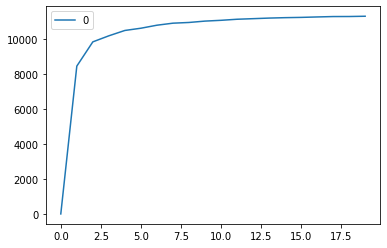

In [20]:
curve = pd.DataFrame(rmse_val) 
curve.plot()

In [21]:
X1_embedded = TSNE(learning_rate=50).fit_transform(X1_select)
X1_embedded.shape

(19822, 2)

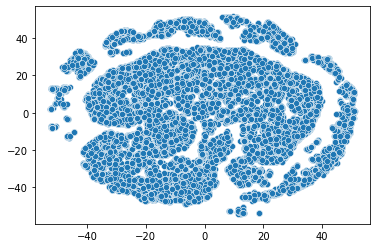

In [22]:
x = X1_embedded[:,0]
y = X1_embedded[:,1]
sns.scatterplot(x,y,data=X1_embedded)
plt.show()

# Multi layer perceptron

In [65]:
mlp = MLPRegressor(random_state=1, max_iter=400)
mlp.fit(X1_select,Y1)

MLPRegressor(max_iter=400, random_state=1)

In [93]:
mlp_pred = mlp.predict(X1_select)
print(math.sqrt(mean_squared_error(Y1,mlp_pred)))

11658.449178337336


In [67]:
check_parameters = {
    'hidden_layer_sizes': [(50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [68]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(X1_select)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,10.0,379.0,0.521622,1.0,0.697248,5.0,2.0,1.0,0.0,4.126649,...,0.368452,0.100000,0.5,-0.244444,-0.500000,-0.050000,0.227273,0.068182,0.272727,0.068182
1,12.0,402.0,0.502660,1.0,0.645299,12.0,10.0,1.0,0.0,4.537313,...,0.270170,0.100000,0.5,-0.159259,-0.166667,-0.155556,0.500000,0.500000,0.000000,0.500000
2,11.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
3,9.0,256.0,0.619608,1.0,0.792208,2.0,0.0,0.0,1.0,4.644531,...,0.245130,0.100000,1.0,-0.500000,-0.500000,-0.500000,0.200000,0.100000,0.300000,0.100000
4,12.0,268.0,0.591603,1.0,0.740260,1.0,1.0,1.0,1.0,4.671642,...,0.539076,0.200000,1.0,-0.254167,-0.500000,-0.050000,0.000000,0.000000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19817,8.0,217.0,0.539604,1.0,0.645669,4.0,2.0,1.0,0.0,4.700461,...,0.416416,0.136364,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
19818,11.0,269.0,0.583643,1.0,0.712575,9.0,0.0,1.0,0.0,4.680297,...,0.288030,0.100000,0.6,-0.361667,-0.666667,-0.166667,0.000000,0.000000,0.500000,0.000000
19819,14.0,130.0,0.723577,1.0,0.845070,1.0,1.0,1.0,0.0,4.700000,...,0.382803,0.100000,0.7,-0.025000,-0.025000,-0.025000,0.533333,0.216667,0.033333,0.216667
19820,10.0,471.0,0.538803,1.0,0.645485,24.0,2.0,1.0,0.0,4.853503,...,0.226212,0.033333,0.8,-0.317836,-1.000000,-0.050000,0.300000,-0.500000,0.200000,0.500000


In [69]:
X1_select.replace([np.inf, -np.inf], np.nan, inplace=True)

In [70]:
gridsearchcv = GridSearchCV(mlp, check_parameters, n_jobs=-1, cv=3)
gridsearchcv.fit(X1_select, Y1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Random forest regressor

In [88]:
rand_forest = RandomForestRegressor(n_estimators=100,random_state=0, criterion="mse")
rand_forest.fit(X1_select,Y1)

RandomForestRegressor(random_state=0)

In [91]:
forest_pred = rand_forest.predict(X1_select)

In [92]:
print(math.sqrt(mean_squared_error(Y1,forest_pred)))

4553.749173446149
